# Proxy Target Variable Engineering

This notebook implements proxy target variable engineering by:
1. Calculating RFM (Recency, Frequency, Monetary) metrics for each customer
2. Clustering customers into 3 distinct groups using K-Means
3. Identifying the high-risk cluster (least engaged customers)
4. Creating a binary target variable `is_high_risk`
5. Integrating the target variable back into the main dataset

## Overview
Since we don't have a pre-existing "credit risk" column, we'll create one by identifying disengaged customers who are likely to be high-risk (those with high likelihood of default).


## Import Required Libraries

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load and Explore the Data

In [3]:
# Load the transaction data
df = pd.read_csv('../data/raw/data.csv')
print(f"Dataset shape: {df.shape}")
print(f"Number of unique customers: {df['CustomerId'].nunique()}")
df.head()

Dataset shape: (95662, 16)
Number of unique customers: 3742


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


## Data Type Conversion

In [4]:
# Check data types and convert TransactionStartTime to datetime
print("=== DATA TYPES BEFORE CONVERSION ===")
print(df.dtypes)

# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

print("\n=== DATA TYPES AFTER CONVERSION ===")
print(df.dtypes)

print(f"\n=== DATE RANGE ===")
print(f"Earliest transaction: {df['TransactionStartTime'].min()}")
print(f"Latest transaction: {df['TransactionStartTime'].max()}")
print(f"Date range: {(df['TransactionStartTime'].max() - df['TransactionStartTime'].min()).days} days")

=== DATA TYPES BEFORE CONVERSION ===
TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object

=== DATA TYPES AFTER CONVERSION ===
TransactionId                        object
BatchId                              object
AccountId                            object
SubscriptionId                       object
CustomerId                           object
CurrencyCode                         object
CountryCode                           int64
ProviderId                           object
ProductId                            object
Prod

## 4: Calculate RFM Metrics

In [5]:
# Define snapshot date (last transaction date + 1 day)
snapshot_date = df['TransactionStartTime'].max() + timedelta(days=1)
print(f"Snapshot date for RFM calculation: {snapshot_date}")

# Calculate RFM metrics
rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,  # Recency (days since last transaction)
    'TransactionId': 'count',  # Frequency (number of transactions)
    'Amount': ['sum', 'mean']  # Monetary (total and average transaction amount)
}).round(2)

# Flatten column names
rfm.columns = ['recency_days', 'frequency', 'monetary_total', 'monetary_avg']
rfm = rfm.reset_index()

print(f"RFM dataset shape: {rfm.shape}")
rfm.head()

Snapshot date for RFM calculation: 2019-02-14 10:01:28+00:00
RFM dataset shape: (3742, 5)


,CustomerId,recency_days,frequency,monetary_total,monetary_avg
0,CustomerId_1,84,1,-10000.0,-10000.00
1,CustomerId_10,84,1,-10000.0,-10000.00
2,CustomerId_1001,90,5,20000.0,4000.00
3,CustomerId_1002,26,11,4225.0,384.09
4,CustomerId_1003,12,6,20000.0,3333.33


## 5: RFM Summary Statistics

In [6]:
# Summary statistics of RFM metrics
print("=== RFM METRICS SUMMARY ===")
print(rfm.describe())

# Check for any missing values
print("\n=== MISSING VALUES ===")
print(rfm.isnull().sum())

=== RFM METRICS SUMMARY ===
       recency_days    frequency  monetary_total  monetary_avg
count   3742.000000  3742.000000    3.742000e+03  3.742000e+03
mean      31.461251    25.564404    1.717377e+05  1.571562e+04
std       27.118932    96.929602    2.717305e+06  1.676991e+05
min        1.000000     1.000000   -1.049000e+08 -4.250000e+05
25%        6.000000     2.000000    4.077438e+03  1.000000e+03
50%       25.000000     7.000000    2.000000e+04  2.583845e+03
75%       54.000000    20.000000    7.996775e+04  4.877610e+03
max       91.000000  4091.000000    8.345124e+07  8.601821e+06

=== MISSING VALUES ===
CustomerId        0
recency_days      0
frequency         0
monetary_total    0
monetary_avg      0
dtype: int64


## 6: Visualize RFM Distributions

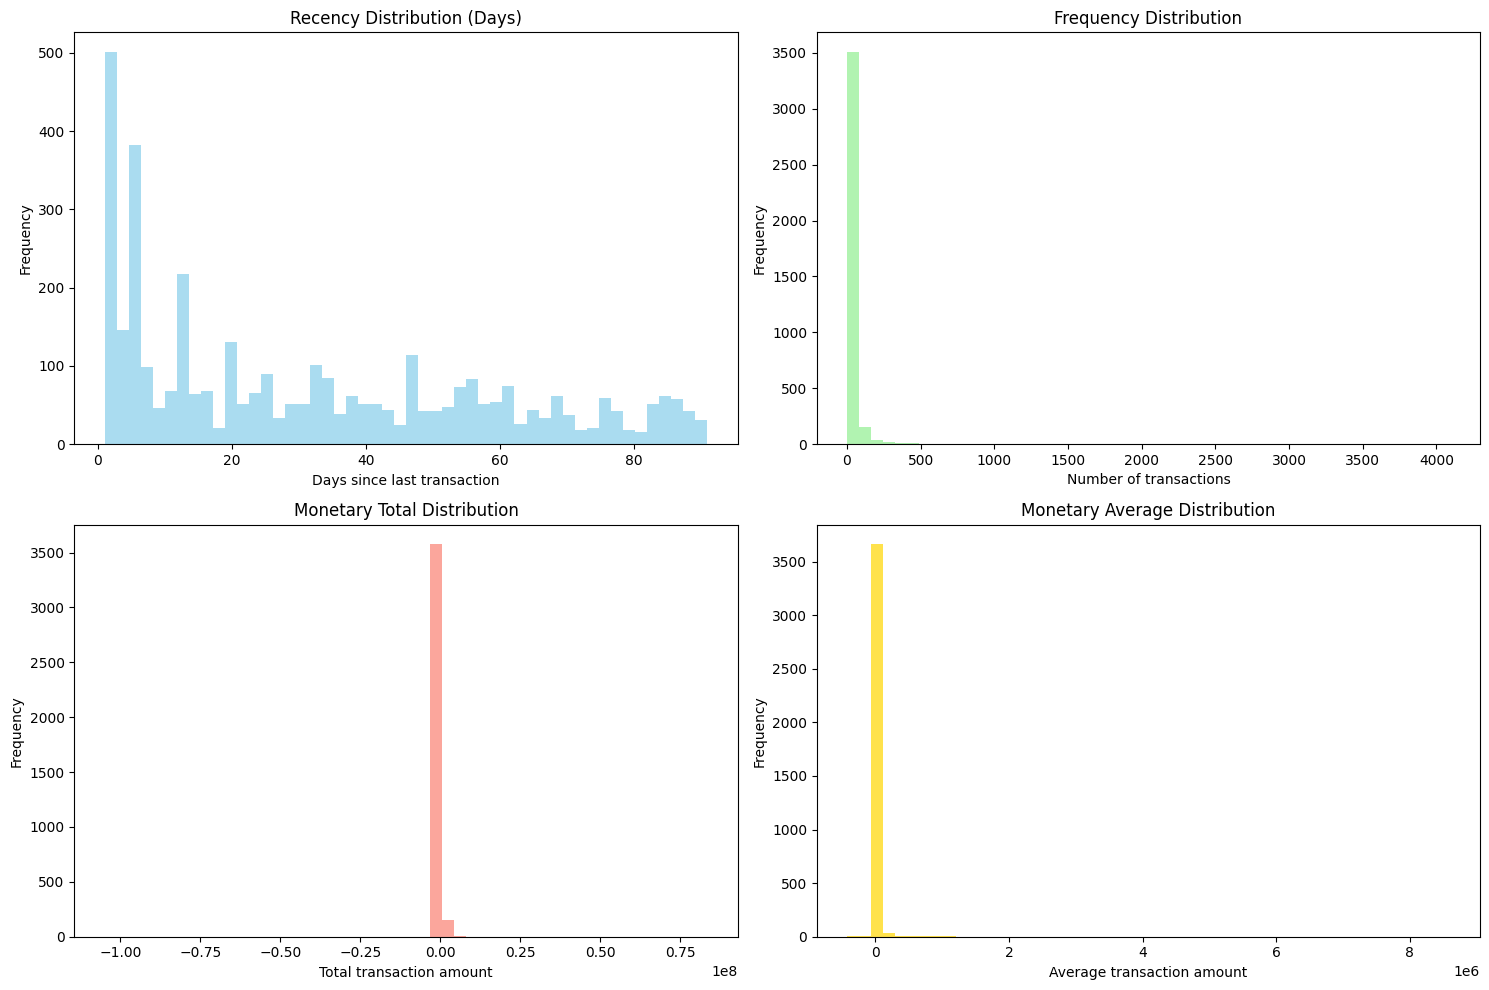

In [7]:
# Visualize RFM distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Recency distribution
axes[0, 0].hist(rfm['recency_days'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Recency Distribution (Days)')
axes[0, 0].set_xlabel('Days since last transaction')
axes[0, 0].set_ylabel('Frequency')

# Frequency distribution
axes[0, 1].hist(rfm['frequency'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Frequency Distribution')
axes[0, 1].set_xlabel('Number of transactions')
axes[0, 1].set_ylabel('Frequency')

# Monetary total distribution
axes[1, 0].hist(rfm['monetary_total'], bins=50, alpha=0.7, color='salmon')
axes[1, 0].set_title('Monetary Total Distribution')
axes[1, 0].set_xlabel('Total transaction amount')
axes[1, 0].set_ylabel('Frequency')

# Monetary average distribution
axes[1, 1].hist(rfm['monetary_avg'], bins=50, alpha=0.7, color='gold')
axes[1, 1].set_title('Monetary Average Distribution')
axes[1, 1].set_xlabel('Average transaction amount')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 7: Data Preprocessing for Clustering

In [8]:
# Select features for clustering (we'll use recency, frequency, and monetary_total)
features_for_clustering = ['recency_days', 'frequency', 'monetary_total']
X = rfm[features_for_clustering].copy()

print("=== FEATURES FOR CLUSTERING ===")
print(X.head())
print(f"\nShape: {X.shape}")

# Check for outliers and extreme values
print("\n=== OUTLIER ANALYSIS ===")
for col in features_for_clustering:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(X)*100:.2f}%)")

=== FEATURES FOR CLUSTERING ===
   recency_days  frequency  monetary_total
0            84          1        -10000.0
1            84          1        -10000.0
2            90          5         20000.0
3            26         11          4225.0
4            12          6         20000.0

Shape: (3742, 3)

=== OUTLIER ANALYSIS ===
recency_days: 0 outliers (0.00%)
frequency: 448 outliers (11.97%)
monetary_total: 470 outliers (12.56%)


## 8: Handle Outliers and Scale Features

In [9]:
# Handle outliers by capping them at the 95th percentile
X_cleaned = X.copy()
for col in features_for_clustering:
    percentile_95 = X[col].quantile(0.95)
    X_cleaned[col] = X_cleaned[col].clip(upper=percentile_95)

print("=== AFTER OUTLIER HANDLING ===")
print(X_cleaned.describe())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering, index=X_cleaned.index)

print("\n=== SCALED FEATURES ===")
print(X_scaled_df.describe())

=== AFTER OUTLIER HANDLING ===
       recency_days    frequency  monetary_total
count   3742.000000  3742.000000    3.742000e+03
mean      31.313736    18.078835    4.386486e+04
std       26.818515    25.768020    1.721580e+06
min        1.000000     1.000000   -1.049000e+08
25%        6.000000     2.000000    4.077438e+03
50%       25.000000     7.000000    2.000000e+04
75%       54.000000    20.000000    7.996775e+04
max       84.000000    98.000000    4.927568e+05

=== SCALED FEATURES ===
       recency_days     frequency  monetary_total
count  3.742000e+03  3.742000e+03    3.742000e+03
mean   6.456027e-17  2.658364e-17   -3.797663e-18
std    1.000134e+00  1.000134e+00    1.000134e+00
min   -1.130480e+00 -6.628805e-01   -6.096604e+01
25%   -9.440164e-01 -6.240675e-01   -2.311408e-02
50%   -2.354560e-01 -4.300026e-01   -1.386404e-02
75%    8.460310e-01  7.456615e-02    2.097360e-02
max    1.964811e+00  3.101979e+00    2.607791e-01


##  9: K-Means Clustering

In [10]:
# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the RFM dataframe
rfm['cluster'] = cluster_labels

print("=== CLUSTERING RESULTS ===")
print(f"Number of clusters: {len(np.unique(cluster_labels))}")
print(f"Cluster distribution:")
print(rfm['cluster'].value_counts().sort_index())

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"\nSilhouette Score: {silhouette_avg:.4f}")

=== CLUSTERING RESULTS ===
Number of clusters: 3
Cluster distribution:
cluster
0    1699
1    2042
2       1
Name: count, dtype: int64

Silhouette Score: 0.4618


## 10: Analyze Cluster Characteristics

In [11]:
# Analyze cluster characteristics
cluster_analysis = rfm.groupby('cluster')[features_for_clustering].agg(['mean', 'std']).round(2)
print("=== CLUSTER CHARACTERISTICS ===")
print(cluster_analysis)

# Create a summary table
cluster_summary = rfm.groupby('cluster').agg({
    'recency_days': 'mean',
    'frequency': 'mean',
    'monetary_total': 'mean',
    'CustomerId': 'count'
}).round(2)
cluster_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
cluster_summary['Customer_Percentage'] = (cluster_summary['Customer_Count'] / len(rfm) * 100).round(2)

print("\n=== CLUSTER SUMMARY ===")
print(cluster_summary)

=== CLUSTER CHARACTERISTICS ===
        recency_days        frequency        monetary_total            
                mean    std      mean    std           mean         std
cluster                                                                
0              56.77  18.16      5.66   8.22   7.516785e+04   777375.95
1              10.41   9.84     40.13  92.33   3.035418e+05  2756230.22
2              29.00    NaN   4091.00    NaN  -1.049000e+08         NaN

=== CLUSTER SUMMARY ===
         Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count  Customer_Percentage
cluster                                                                               
0              56.77           5.66  7.516785e+04            1699                45.40
1              10.41          40.13  3.035418e+05            2042                54.57
2              29.00        4091.00 -1.049000e+08               1                 0.03


## 11: Visualize Clusters

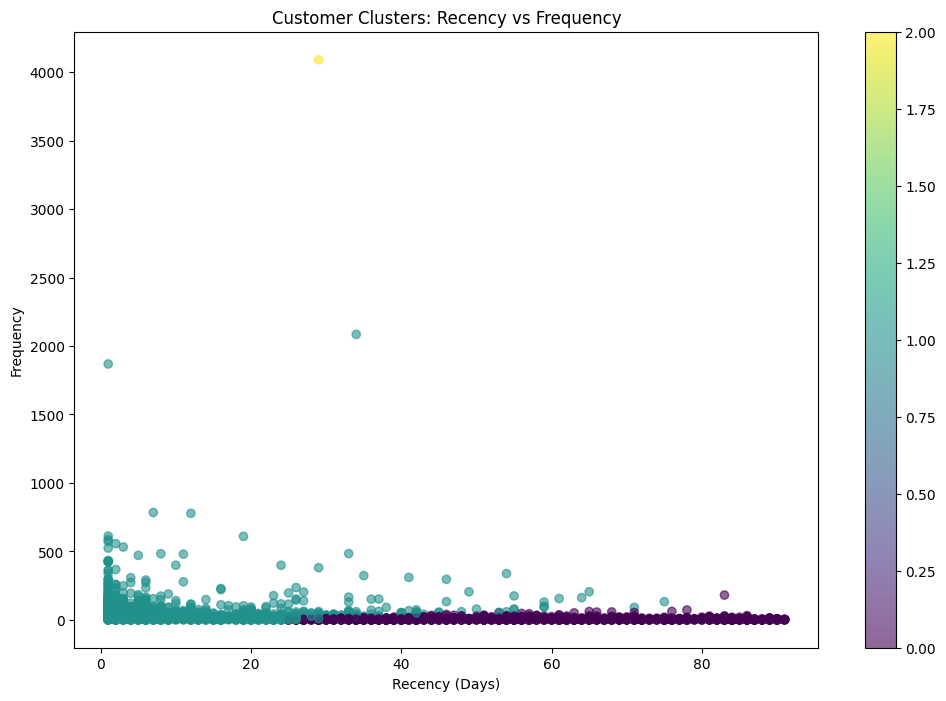

In [12]:
# Visualize clusters in 3D space
fig = px.scatter_3d(
    rfm, 
    x='recency_days', 
    y='frequency', 
    z='monetary_total',
    color='cluster',
    title='Customer Clusters in RFM Space',
    labels={'recency_days': 'Recency (Days)', 'frequency': 'Frequency', 'monetary_total': 'Monetary Total'}
)
fig.show()

# 2D scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm['recency_days'], rfm['frequency'], c=rfm['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.title('Customer Clusters: Recency vs Frequency')
plt.show()

## 12: Identify High-Risk Cluster

In [13]:
# Determine the high-risk cluster
# We'll identify the cluster with the highest risk score
cluster_risk_scores = {}
for cluster_id in sorted(rfm['cluster'].unique()):
    cluster_data = rfm[rfm['cluster'] == cluster_id]
    
    # Calculate risk indicators
    high_recency = cluster_data['recency_days'].mean() > rfm['recency_days'].mean()
    low_frequency = cluster_data['frequency'].mean() < rfm['frequency'].mean()
    low_monetary = cluster_data['monetary_total'].mean() < rfm['monetary_total'].mean()
    
    risk_score = sum([high_recency, low_frequency, low_monetary])
    cluster_risk_scores[cluster_id] = risk_score

print("=== CLUSTER RISK SCORES ===")
for cluster_id, score in cluster_risk_scores.items():
    print(f"Cluster {cluster_id}: Risk Score = {score}/3")

# Identify the high-risk cluster (highest risk score)
high_risk_cluster = max(cluster_risk_scores, key=cluster_risk_scores.get)
print(f"\nHigh-risk cluster identified: Cluster {high_risk_cluster}")
print(f"Risk score: {cluster_risk_scores[high_risk_cluster]}/3")

=== CLUSTER RISK SCORES ===
Cluster 0: Risk Score = 3/3
Cluster 1: Risk Score = 0/3
Cluster 2: Risk Score = 1/3

High-risk cluster identified: Cluster 0
Risk score: 3/3


## 13: Create Binary Target Variable

In [14]:
# Create binary target variable
rfm['is_high_risk'] = (rfm['cluster'] == high_risk_cluster).astype(int)

print("=== TARGET VARIABLE CREATION ===")
print(f"High-risk customers: {rfm['is_high_risk'].sum()} ({rfm['is_high_risk'].sum()/len(rfm)*100:.2f}%)")
print(f"Low-risk customers: {(rfm['is_high_risk'] == 0).sum()} ({(rfm['is_high_risk'] == 0).sum()/len(rfm)*100:.2f}%)")

# Display target variable distribution
print("\n=== TARGET VARIABLE DISTRIBUTION ===")
print(rfm['is_high_risk'].value_counts().sort_index())

=== TARGET VARIABLE CREATION ===
High-risk customers: 1699 (45.40%)
Low-risk customers: 2043 (54.60%)

=== TARGET VARIABLE DISTRIBUTION ===
is_high_risk
0    2043
1    1699
Name: count, dtype: int64


## 14: Analyze Risk Class Characteristics

In [15]:
# Analyze characteristics of high-risk vs low-risk customers
risk_analysis = rfm.groupby('is_high_risk')[features_for_clustering].agg(['mean', 'std']).round(2)
print("=== RISK CLASS CHARACTERISTICS ===")
print(risk_analysis)

# Create comparison table
comparison = rfm.groupby('is_high_risk').agg({
    'recency_days': 'mean',
    'frequency': 'mean',
    'monetary_total': 'mean',
    'CustomerId': 'count'
}).round(2)
comparison.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
comparison.index = ['Low Risk', 'High Risk']

print("\n=== RISK CLASS COMPARISON ===")
print(comparison)

=== RISK CLASS CHARACTERISTICS ===
             recency_days        frequency         monetary_total            
                     mean    std      mean     std           mean         std
is_high_risk                                                                 
0                   10.42   9.85     42.12  128.66      252047.21  3607007.47
1                   56.77  18.16      5.66    8.22       75167.85   777375.95

=== RISK CLASS COMPARISON ===
           Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
Low Risk         10.42          42.12     252047.21            2043
High Risk        56.77           5.66      75167.85            1699


## 15: Visualize Target Variable Distribution

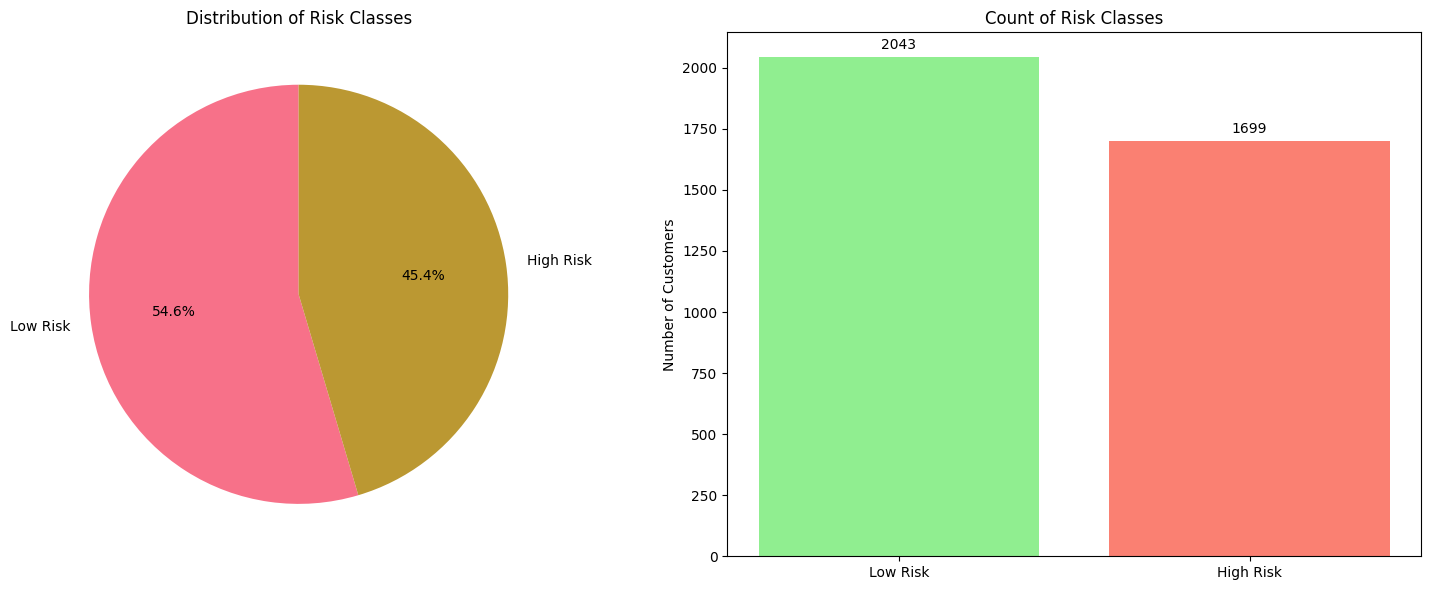

In [16]:
# Visualize the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
risk_counts = rfm['is_high_risk'].value_counts()
axes[0].pie(risk_counts.values, labels=['Low Risk', 'High Risk'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of Risk Classes')

# Bar chart
axes[1].bar(['Low Risk', 'High Risk'], risk_counts.values, color=['lightgreen', 'salmon'])
axes[1].set_title('Count of Risk Classes')
axes[1].set_ylabel('Number of Customers')
for i, v in enumerate(risk_counts.values):
    axes[1].text(i, v + max(risk_counts.values) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 16: Create Final Target Dataset

In [17]:
# Select only the necessary columns for the final dataset
target_dataset = rfm[['CustomerId', 'recency_days', 'frequency', 'monetary_total', 'monetary_avg', 'cluster', 'is_high_risk']].copy()

print("=== FINAL TARGET DATASET ===")
print(f"Shape: {target_dataset.shape}")
print(f"Columns: {list(target_dataset.columns)}")
target_dataset.head()

=== FINAL TARGET DATASET ===
Shape: (3742, 7)
Columns: ['CustomerId', 'recency_days', 'frequency', 'monetary_total', 'monetary_avg', 'cluster', 'is_high_risk']


,CustomerId,recency_days,frequency,monetary_total,monetary_avg,cluster,is_high_risk
0,CustomerId_1,84,1,-10000.0,-10000.00,0,1
1,CustomerId_10,84,1,-10000.0,-10000.00,0,1
2,CustomerId_1001,90,5,20000.0,4000.00,0,1
3,CustomerId_1002,26,11,4225.0,384.09,1,0
4,CustomerId_1003,12,6,20000.0,3333.33,1,0


## 17: Save Datasets

In [18]:
# Save the target dataset
target_dataset.to_csv('../data/processed/customer_risk_target.csv', index=False)
print("Target dataset saved to '../data/processed/customer_risk_target.csv'")

# Also save the RFM dataset with all information
rfm.to_csv('../data/processed/rfm_with_target.csv', index=False)
print("RFM dataset with target saved to '../data/processed/rfm_with_target.csv'")

# Display summary of saved data
print(f"\n=== SAVED DATASET SUMMARY ===")
print(f"Total customers: {len(target_dataset)}")
print(f"High-risk customers: {target_dataset['is_high_risk'].sum()} ({target_dataset['is_high_risk'].sum()/len(target_dataset)*100:.2f}%)")
print(f"Low-risk customers: {(target_dataset['is_high_risk'] == 0).sum()} ({(target_dataset['is_high_risk'] == 0).sum()/len(target_dataset)*100:.2f}%)")

Target dataset saved to '../data/processed/customer_risk_target.csv'
RFM dataset with target saved to '../data/processed/rfm_with_target.csv'

=== SAVED DATASET SUMMARY ===
Total customers: 3742
High-risk customers: 1699 (45.40%)
Low-risk customers: 2043 (54.60%)


## 18: Quality Checks

In [19]:
# Quality checks
print("=== QUALITY CHECKS ===")

# Check for missing values
print("1. Missing values:")
print(target_dataset.isnull().sum())

# Check for duplicate CustomerIds
print(f"\n2. Duplicate CustomerIds: {target_dataset['CustomerId'].duplicated().sum()}")

# Verify target variable distribution
print(f"\n3. Target variable distribution:")
print(target_dataset['is_high_risk'].value_counts().sort_index())

# Check data types
print(f"\n4. Data types:")
print(target_dataset.dtypes)

# Verify RFM metrics are reasonable
print(f"\n5. RFM metrics validation:")
print(f"   - Recency range: {target_dataset['recency_days'].min():.0f} to {target_dataset['recency_days'].max():.0f} days")
print(f"   - Frequency range: {target_dataset['frequency'].min():.0f} to {target_dataset['frequency'].max():.0f} transactions")
print(f"   - Monetary range: {target_dataset['monetary_total'].min():.2f} to {target_dataset['monetary_total'].max():.2f}")

=== QUALITY CHECKS ===
1. Missing values:
CustomerId        0
recency_days      0
frequency         0
monetary_total    0
monetary_avg      0
cluster           0
is_high_risk      0
dtype: int64

2. Duplicate CustomerIds: 0

3. Target variable distribution:
is_high_risk
0    2043
1    1699
Name: count, dtype: int64

4. Data types:
CustomerId         object
recency_days        int64
frequency           int64
monetary_total    float64
monetary_avg      float64
cluster             int32
is_high_risk        int64
dtype: object

5. RFM metrics validation:
   - Recency range: 1 to 91 days
   - Frequency range: 1 to 4091 transactions
   - Monetary range: -104900000.00 to 83451240.00


## 19: Final Summary

In [21]:
# Final summary
print("=== COMPLETION SUMMARY ===")
print(f"✅ RFM metrics calculated for {len(rfm)} customers")
print(f"✅ Customers clustered into {len(rfm['cluster'].unique())} groups using K-Means")
print(f"✅ High-risk cluster identified: Cluster {high_risk_cluster}")
print(f"✅ Binary target variable 'is_high_risk' created")
print(f"✅ Target dataset saved with {target_dataset['is_high_risk'].sum()} high-risk customers ({target_dataset['is_high_risk'].sum()/len(target_dataset)*100:.2f}%)")
print(f"✅ Silhouette score: {silhouette_avg:.4f}")

print(f"\n=== DATASET FILES CREATED ===")
print("1. '../data/processed/customer_risk_target.csv' - Main target dataset")
print("2. '../data/processed/rfm_with_target.csv' - RFM dataset with target variable")

print(f"\n=== NEXT STEPS ===")
print("1. Use the target dataset for model training")
print("2. Combine with other features for comprehensive credit risk modeling")
print("3. Validate the proxy target variable with domain experts")
print("4. Monitor model performance and adjust risk thresholds if needed")

=== COMPLETION SUMMARY ===
✅ RFM metrics calculated for 3742 customers
✅ Customers clustered into 3 groups using K-Means
✅ High-risk cluster identified: Cluster 0
✅ Binary target variable 'is_high_risk' created
✅ Target dataset saved with 1699 high-risk customers (45.40%)
✅ Silhouette score: 0.4618

=== DATASET FILES CREATED ===
1. '../data/processed/customer_risk_target.csv' - Main target dataset
2. '../data/processed/rfm_with_target.csv' - RFM dataset with target variable

=== NEXT STEPS ===
1. Use the target dataset for model training
2. Combine with other features for comprehensive credit risk modeling
3. Validate the proxy target variable with domain experts
4. Monitor model performance and adjust risk thresholds if needed
